In [2]:
import numpy as np
import pandas as pd
from random import randint

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [4]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [5]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

 
 ---
 ---

### 1. Create Train - Test - Split

In [6]:
def tts():
    Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

    for task in training_tasks:
        X_test, y_test, X_train, y_train = [], [], [], []

        for pair in task["test"]:
            X_test.append(pair["input"])
            y_test.append(pair["output"])      ### to be predicted !!!

        for pair in task["train"]:
            X_train.append(pair["input"])
            y_train.append(pair["output"])

        Xs_test.append(X_test)
        ys_test.append(y_test)
        Xs_train.append(X_train)
        ys_train.append(y_train)
    return Xs_test, ys_test, Xs_train, ys_train

In [7]:
Xs_test_orig, ys_test_orig, Xs_train_orig, ys_train_orig = tts()

In [8]:
len(Xs_train_orig), len(ys_train_orig), len(Xs_test_orig), len(ys_test_orig)

(400, 400, 400, 400)

In [9]:
len(Xs_train_orig[0]), len(ys_train_orig[0]), len(Xs_test_orig[0]), len(ys_test_orig[0])

(5, 5, 1, 1)

In [10]:
Xs_test, ys_test, Xs_train, ys_train = tts()

In [11]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [12]:
len(Xs_train[0]), len(ys_train[0]), len(Xs_test[0]), len(ys_test[0])

(5, 5, 1, 1)

## Data Augmentation of the training data

In [13]:
def augm(X_list, y_list):
    idx = 1
    X_list_new = X_list
    y_list_new = y_list
    for task_X, task_y in zip(X_list, y_list):
#         print("TASK",idx)
        while len(task_X) < 100:
            """
            choose a random method and append new array
            """
#             print(len(task_X))
            i = randint(0,len(task_X)-1) 
            new_x = task_X[i]
            new_y = task_y[i]
            
            task_X.append(new_x)
            task_y.append(new_y)
            
#         X_list_new.append(task_X)
#         y_list_new.append(task_X)
        idx +=1
    return task_X,task_y
            
#     return X_list_new,y_list_new
        
        
        
        
# ### flipping

# np.fliplr(rep)

# np.flipud(rep)

# ### rotate 90

# np.rot90(rep)



# ### color

# x = (Xs_train_tasks[0]*10)[0].reshape(32,32)

# abs(x-1)

In [14]:
augm(Xs_train, ys_train)

([[[0, 3, 3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 0],
   [3, 3, 3, 3, 3, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 3],
   [3, 3, 3, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 1, 3],
   [3, 3, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3],
   [3, 3, 0, 3, 3, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 3],
   [0, 0, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 3, 0, 0],
   [0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0],
   [2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2],
   [2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2],
   [2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2],
   [0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0],
   [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0],

In [15]:
len(Xs_train[0]), len(ys_train[0]), len(Xs_test[0]), len(ys_test[0])

(100, 100, 1, 1)

In [16]:
np.asarray(Xs_train[0]).shape

(100, 3, 3)

In [17]:
def prep_tasks(split_list):
    split_tasks = []
    for task in split_list:
        li=[]
        for e in task:
            e = np.array(e)
            e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
            e = e / 10.
            e = e.reshape(e.shape + (1,) )
            li.append(e)
        li = np.array(li)
        split_tasks.append(li)
    return split_tasks

In [18]:
Xs_train_tasks = prep_tasks(Xs_train)
Xs_test_tasks = prep_tasks(Xs_test)
ys_train_tasks = prep_tasks(ys_train)
ys_test_tasks = prep_tasks(ys_test)



In [19]:
type(Xs_train_tasks), type(ys_train_tasks), type(Xs_test_tasks), type(ys_test_tasks)

(list, list, list, list)

In [20]:
len(Xs_train_tasks), len(ys_train_tasks), len(Xs_test_tasks), len(ys_test_tasks)

(400, 400, 400, 400)

In [21]:
len(Xs_train_tasks[0]), len(ys_train_tasks[0]), len(Xs_test_tasks[0]), len(ys_test_tasks[0])

(100, 100, 1, 1)

In [22]:
Xs_train_tasks[0].shape,ys_train_tasks[0].shape, Xs_test_tasks[0].shape, ys_test_tasks[0].shape

((100, 32, 32, 1), (100, 32, 32, 1), (1, 32, 32, 1), (1, 32, 32, 1))

In [23]:
flattened_list = [y for x in Xs_train_tasks for y in x]

In [24]:
Xs_train_tasks = [y for x in Xs_train_tasks for y in x]
ys_train_tasks = [y for x in ys_train_tasks for y in x]
Xs_test_tasks = [y for x in Xs_test_tasks for y in x]
ys_test_tasks = [y for x in ys_test_tasks for y in x]

In [25]:
#########################################################
##### test if the test_tasks are all the same shape #####
#########################################################

In [26]:
Xs_train_tasks = np.asarray(Xs_train_tasks)
ys_train_tasks = np.asarray(ys_train_tasks)
Xs_test_tasks = np.asarray(Xs_test_tasks)
ys_test_tasks = np.asarray(ys_test_tasks)

In [27]:
Xs_train_tasks.shape,ys_train_tasks.shape, Xs_test_tasks.shape, ys_test_tasks.shape

((40000, 32, 32, 1), (40000, 32, 32, 1), (416, 32, 32, 1), (416, 32, 32, 1))

## Model comp

In [28]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (32,32,1)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(1024, activation='sigmoid'),
            layers.Reshape((32, 32,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
K.clear_session() 

In [30]:

latent_dim = 64 
idx = 0
#start = time.time()

model = Sequential()
base_model = Autoencoder(latent_dim)

base_model.compile(optimizer='adam', 
                          loss='mean_squared_error',
                          metrics=['accuracy'])
    
callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5)

base_model.fit(Xs_train_tasks, ys_train_tasks,
                      epochs=100,
                      batch_size=5000,
                      #shuffle=True,
                      callbacks=[callback],
                      
                      validation_data=(Xs_test_tasks, ys_test_tasks))
    


Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 0.2373 - accuracy: 0.6923 - val_loss: 0.2219 - val_accuracy: 0.8129
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.1948 - accuracy: 0.8876 - val_loss: 0.1321 - val_accuracy: 0.9270
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.0811 - accuracy: 0.9460 - val_loss: 0.0267 - val_accuracy: 0.9368
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.0163 - accuracy: 0.9505 - val_loss: 0.0138 - val_accuracy: 0.9386
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 0.0115 - accuracy: 0.9509 - val_loss: 0.0136 - val_accuracy: 0.9386
Epoch 6/100
8/8 [==============================] - 12s 1s/step - loss: 0.0114 - accuracy: 0.9509 - val_loss: 0.0136 - val_accuracy: 0.9386
Epoch 7/100
8/8 [==============================] - 10s 1s/step - loss: 0.0113 - accuracy: 0.9509 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 8/100
8/8 [==========

In [32]:
base_model.encoder.summary()
base_model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                262208    
Total params: 262,368
Trainable params: 262,368
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              66560     
__________________________

In [ ]:
# # K.clear_session()   #clean slate
# latent_dim = 64 
# idx = 0
# #start = time.time()

# model = Sequential()

# for X_train, y_train, X_test, y_test in zip(Xs_train_tasks, ys_train_tasks,Xs_test_tasks, ys_test_tasks):    
#     print("TASK " + str(idx + 1))
    

#     base_model = Autoencoder(latent_dim)

#     base_model.compile(optimizer='adam', 
#                           loss='mean_squared_error',
#                           metrics=['accuracy'])
    
#     callback = keras.callbacks.EarlyStopping(monitor='accuracy',
#                                              patience=5)
    
#     if idx == 0 or idx == 398:
#         base_model.fit(X_train, y_train,
#                       epochs=100,
#                       batch_size=5000,
#                       #shuffle=True,
# #                       verbose=0,
#                       callbacks=[callback],
#                       validation_data=(X_test, y_test))
    
    
#     else:
#         base_model.fit(X_train, y_train,
#                       epochs=100,
#                       batch_size=5000,
#                       #shuffle=True,
#                       callbacks=[callback],
#                       verbose=0,
#                       validation_data=(X_test, y_test))
    

        
# #     else:
# #         for layer in base_model.layers:
# #             layer.trainable = False
        
# # #         model = Sequential()
# #         model.add(base_model)
# #    #     model.add(Autoencoder(latent_dim))
# # #         model.name=f"model_{idx}"
# #         print(model.name)
        
        
# #         model.compile(optimizer='adam', 
# #                           loss='mean_squared_error',
# #                           metrics=['accuracy'])

# # #         model.fit(X_train, y_train,
# # #                       epochs=10,
# # #                       batch_size=5000,
# # #                       #shuffle=True,
# # #                   verbose=0,
# # #                       validation_data=(X_test, y_test))
        
# # #         base_model = model
# #         print(model.summary()) 
#     idx += 1

## MAKE PREDICTIONS

In [ ]:
encoded_imgs = base_model.encoder(Xs_test_tasks[125]).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

In [ ]:
decoded_imgs.shape

In [ ]:
w = Xs_test_tasks[125:126][0]#.shape

In [ ]:
w.shape

In [ ]:
v = w*10

In [ ]:
y = ys_test_tasks[125].reshape(32,32)

In [ ]:
y.shape

In [ ]:
y=y*10

In [ ]:
y

In [ ]:
base_model.predict(w)#.shape

In [ ]:
pred = base_model.predict(w).reshape(1,32,32)

In [ ]:
pred.shape

In [ ]:
arr=(decoded_imgs[0].reshape(32,32))*10

In [ ]:
new_arr = np.around(pred,1)*10

In [ ]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 4, figsize=(15,15))
ax[0].imshow(v[0], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(new_arr[0], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(arr, cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2');

In [39]:
i = 0
c = 0
for task in Xs_train_orig:
    i+=1
    j = 0
    for e in task:
        j+=1
        c += 1
        if c > 124:
            break
    if c > 124:
        break

In [40]:
i,j

(40, 3)

In [45]:
Xs_train_tasks.shape

(40000, 32, 32, 1)

#### plotting example

In [33]:
ww = (np.array(Xs_train_tasks[4000]).reshape(32,32))*10

vv = (np.array(ys_train_tasks[4000]).reshape(32,32))*10

tt = ww.reshape(1,32,32,1)

encoded_imgs = base_model.encoder(tt).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

arr=(decoded_imgs[0].reshape(32,32))*10

test = (np.array(Xs_test_tasks[40]).reshape(32,32))*10

test_pred = test.reshape(1,32,32,1)
encoded_imgs2 = base_model.encoder(test_pred).numpy()
decoded_imgs2 = base_model.decoder(encoded_imgs2).numpy()
test_pred = (decoded_imgs2[0].reshape(32,32))*100

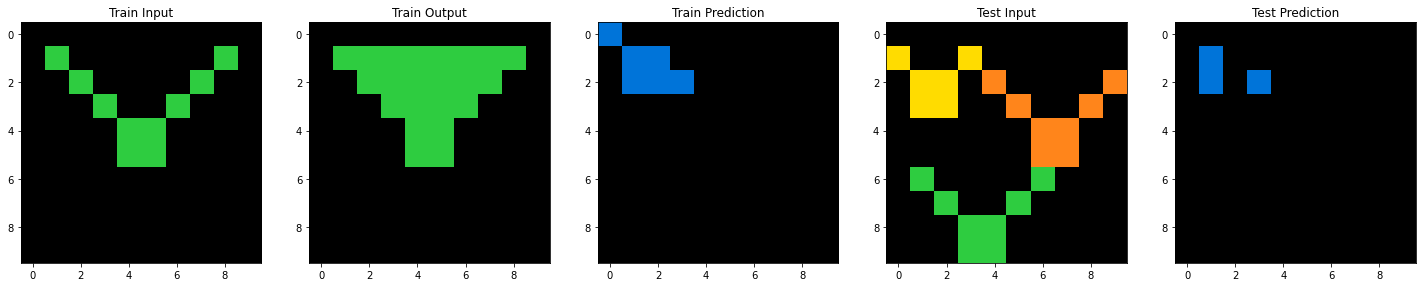

In [62]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 5, figsize=(25,25))
ax[0].imshow(ww[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(vv[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(arr[:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(test[:10,:10], cmap=cmap, norm=norm)
ax[3].set_title('Test Input')
ax[4].imshow(test_pred[:10,:10], cmap=cmap, norm=norm)
ax[4].set_title('Test Prediction');


#### plotting 2nd example

In [166]:
ww = (np.array(Xs_train_tasks[101]).reshape(32,32))*10

In [167]:
ww[:10,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 3., 0., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 0., 3., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 3., 0., 0.],
       [0., 0., 0., 3., 0., 3., 3., 0., 0., 0.],
       [0., 0., 3., 3., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [168]:
vv = (np.array(ys_train_tasks[101]).reshape(32,32))*10

In [169]:
tt = (np.array(Xs_train_tasks[101]).reshape(1,32,32,1))*10

In [170]:
encoded_imgs = base_model.encoder(tt).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

In [173]:
arr=(decoded_imgs[0].reshape(32,32))*100

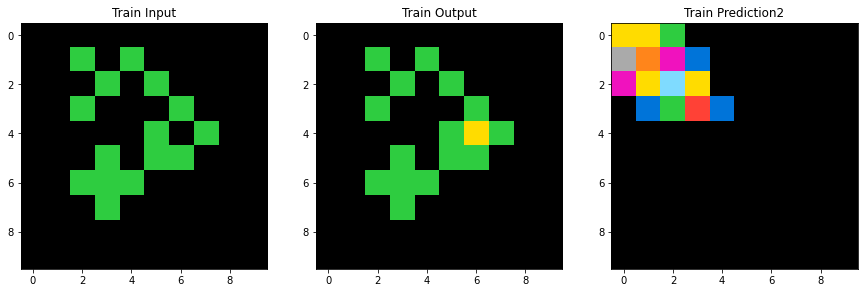

In [174]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(ww[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(vv[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
# ax[2].imshow(new_arr[0][:10,:10], cmap=cmap, norm=norm)
# ax[2].set_title('Train Prediction')
ax[2].imshow(arr[:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction2');

In [72]:
arr[:10,:10]#.shape

array([[7.6913476e-01, 6.7524731e-01, 5.5294454e-01, 6.5107942e-02,
        5.1132527e-05, 2.0714483e-04, 1.0739924e-04, 1.7306498e-05,
        5.9775139e-05, 5.1186395e-05],
       [9.0068072e-01, 1.0388699e+00, 9.8821223e-01, 3.2047004e-01,
        8.3824992e-03, 1.9329786e-03, 1.7268508e-04, 2.1398067e-03,
        1.3419636e-05, 1.8100018e-04],
       [9.3693465e-01, 7.8053445e-01, 1.1550504e+00, 7.2323352e-01,
        1.2060737e-03, 4.9158552e-04, 1.7299512e-04, 2.1428481e-04,
        2.0210842e-05, 1.3063513e-04],
       [1.8011476e-04, 3.0822337e-01, 5.4858595e-01, 5.5263758e-01,
        2.8241426e-01, 3.5703182e-03, 9.5627947e-05, 1.5242789e-04,
        2.9567032e-05, 5.3707199e-06],
       [7.4763186e-05, 1.1705123e-04, 8.1829523e-04, 1.7582059e-01,
        7.4478984e-03, 5.5381656e-03, 3.6123395e-03, 1.7944456e-06,
        8.4946339e-05, 2.2092613e-04],
       [3.6689939e-06, 5.8475236e-04, 5.5605173e-03, 3.2084286e-02,
        5.1111006e-04, 5.2651763e-03, 1.6614795e-03, 9.87

In [ ]:
np.asarray(Xs_train_orig[40][0]).shape, np.asarray(ys_train_orig[40][0]).shape